In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
from functools import reduce
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# 분류모델 import 
# Logistic Regression,SGD,KNN,SVM,Decision Tree, Random Forest, LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,roc_auc_score,f1_score

lr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
lgbm = LGBMClassifier()

In [29]:
df_coldwave = pd.read_csv('./data/preprocessed/df_coldwave.csv',encoding='cp949',index_col=0)
df_kr = pd.read_csv('./data/preprocessed/국내기후(백령도제외).csv',index_col=0)

In [30]:
df_coldwave.drop(['연도','날짜','지점'],axis=1,inplace=True)

In [31]:
# 중복된 날짜 제거 
df_coldwave = df_coldwave.drop_duplicates()

In [32]:
df_kr.rename(columns={'시간':'일시'},inplace=True)

In [33]:
df_kr.columns

Index(['일시', '관측지점', '평균 기온', '최저 기온', '최고 기온', '1시간 최다강수량', '일강수량', '최대 순간풍속',
       '최대 순간 풍속 풍향', '최대 풍속', '최대 풍속 풍향', '평균 풍속', '풍정합', '최대 풍향', '평균 이슬점온도',
       '평균 상대습도', '평균 증기압', '평균 현지기압', '최고 해면 기압', '최저 해면기압', '평균 해면기압',
       '합계 일조 시간', '1시간 최다 일사량', '합계 일사', '일 최심신적설', '일 최심적설', '합계 3시간 신적설',
       '평균 전운량', '평균 중하층운량', '평균 지면온도', '합계 대형증발량', '합계 소형증발량', '안개 계속 시간'],
      dtype='object')

In [34]:
tdf = pd.DataFrame({'일시':df_kr['일시'].unique()})
gunjip = list(df_kr['관측지점'].unique())
for hpa in gunjip:
    tmp = df_kr[df_kr['관측지점']==hpa].drop('관측지점',axis=1)
    tmp.columns = ['일시', f'{hpa}평균기온', f'{hpa}최저기온', f'{hpa}최고기온', f'{hpa}1시간 최다강수량', f'{hpa}일강수량', f'{hpa}최대 순간풍속', f'{hpa}최대 순간 풍속 풍향', f'{hpa}최대 풍속',
                   f'{hpa}최대 풍속 풍향',f'{hpa}평균 풍속',f'{hpa}풍정합',f'{hpa}최대 풍향',f'{hpa}평균 이슬점온도',f'{hpa}평균 상대습도'
                  ,f'{hpa}평균 증기압',f'{hpa}평균 현지기압',f'{hpa}최고 해면 기압',f'{hpa}최저 해면기압',f'{hpa}평균 해면기압',f'{hpa}합계 일조 시간',f'{hpa}1시간 최다 일사량',f'{hpa}합계 일사',
                   f'{hpa}일 최심신적설',f'{hpa}일 최심적설',f'{hpa}합계 3시간 신적설',f'{hpa}평균 전운량',f'{hpa}평균 중하층운량',f'{hpa}평균 지면온도',f'{hpa}합계 대형증발량',f'{hpa}합계 소형증발량',f'{hpa}안개 계속 시간']
    tdf = pd.merge(tdf,tmp, how='left',on='일시')
tdf

,일시,서울평균기온,서울최저기온,서울최고기온,서울1시간 최다강수량,서울일강수량,서울최대 순간풍속,서울최대 순간 풍속 풍향,서울최대 풍속,서울최대 풍속 풍향,...,제주합계 일사,제주일 최심신적설,제주일 최심적설,제주합계 3시간 신적설,제주평균 전운량,제주평균 중하층운량,제주평균 지면온도,제주합계 대형증발량,제주합계 소형증발량,제주안개 계속 시간
0,1990-01-01,-1.7,-4.0,1.8,0.0,0.0,7.3,270.0,5.0,270.0,...,5.52,0.0,0.0,0.0,5.3,5.8,4.6,1.0,1.4,0.0
1,1990-01-02,-3.5,-5.7,-0.9,0.0,0.1,8.6,290.0,4.8,290.0,...,2.65,0.0,0.0,0.0,8.8,8.1,4.6,1.0,1.6,0.0
2,1990-01-03,-5.0,-7.2,-1.7,0.0,0.0,8.2,290.0,5.0,290.0,...,2.40,0.0,0.0,0.0,9.3,9.3,3.2,1.0,1.6,0.0
3,1990-01-04,-3.3,-8.9,2.1,0.0,0.0,6.1,290.0,3.0,290.0,...,2.89,0.0,0.0,0.0,8.0,8.4,3.5,0.8,1.1,0.0
4,1990-01-05,0.7,-2.4,2.1,0.0,3.2,12.3,290.0,7.2,290.0,...,4.64,0.0,0.0,0.0,7.5,5.8,6.5,1.0,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11683,2021-12-27,-7.6,-12.9,-3.9,0.0,0.0,5.5,340.0,3.1,20.0,...,1.37,0.5,1.2,0.5,8.1,8.1,3.9,1.0,1.4,0.0
11684,2021-12-28,-4.1,-8.5,-0.9,0.0,0.0,4.9,50.0,3.1,50.0,...,0.91,0.0,0.0,0.0,8.3,8.0,5.6,0.9,1.3,0.0
11685,2021-12-29,0.4,-3.8,5.9,0.0,0.2,10.8,270.0,5.9,270.0,...,4.94,0.0,0.0,0.0,8.5,7.8,6.9,2.3,3.3,0.0
11686,2021-12-30,-3.9,-6.8,0.2,0.0,0.0,12.3,320.0,6.6,290.0,...,4.85,0.0,0.0,0.0,8.0,8.0,5.9,2.3,3.2,0.0


1990-01-01    1
2011-04-25    1
2011-04-27    1
2011-04-28    1
2011-04-29    1
             ..
2000-09-03    1
2000-09-04    1
2000-09-05    1
2000-09-06    1
2021-12-31    1
Name: 일시, Length: 11688, dtype: int64

In [38]:
cold_kr

,일시,재난일어난날,서울평균기온,서울최저기온,서울최고기온,서울1시간 최다강수량,서울일강수량,서울최대 순간풍속,서울최대 순간 풍속 풍향,서울최대 풍속,...,제주합계 일사,제주일 최심신적설,제주일 최심적설,제주합계 3시간 신적설,제주평균 전운량,제주평균 중하층운량,제주평균 지면온도,제주합계 대형증발량,제주합계 소형증발량,제주안개 계속 시간
0,1990-01-01,1990-01-01,-1.7,-4.0,1.8,0.0,0.0,7.3,270.0,5.0,...,5.52,0.0,0.0,0.0,5.3,5.8,4.6,1.0,1.4,0.0
1,1990-01-02,1990-01-02,-3.5,-5.7,-0.9,0.0,0.1,8.6,290.0,4.8,...,2.65,0.0,0.0,0.0,8.8,8.1,4.6,1.0,1.6,0.0
2,1990-01-03,1990-01-03,-5.0,-7.2,-1.7,0.0,0.0,8.2,290.0,5.0,...,2.40,0.0,0.0,0.0,9.3,9.3,3.2,1.0,1.6,0.0
3,1990-01-04,1990-01-04,-3.3,-8.9,2.1,0.0,0.0,6.1,290.0,3.0,...,2.89,0.0,0.0,0.0,8.0,8.4,3.5,0.8,1.1,0.0
4,1990-01-05,NaN,0.7,-2.4,2.1,0.0,3.2,12.3,290.0,7.2,...,4.64,0.0,0.0,0.0,7.5,5.8,6.5,1.0,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11683,2021-12-27,2021-12-27,-7.6,-12.9,-3.9,0.0,0.0,5.5,340.0,3.1,...,1.37,0.5,1.2,0.5,8.1,8.1,3.9,1.0,1.4,0.0
11684,2021-12-28,2021-12-28,-4.1,-8.5,-0.9,0.0,0.0,4.9,50.0,3.1,...,0.91,0.0,0.0,0.0,8.3,8.0,5.6,0.9,1.3,0.0
11685,2021-12-29,NaN,0.4,-3.8,5.9,0.0,0.2,10.8,270.0,5.9,...,4.94,0.0,0.0,0.0,8.5,7.8,6.9,2.3,3.3,0.0
11686,2021-12-30,NaN,-3.9,-6.8,0.2,0.0,0.0,12.3,320.0,6.6,...,4.85,0.0,0.0,0.0,8.0,8.0,5.9,2.3,3.2,0.0


In [37]:
# 주변국과 바다기후를  merge
cold_kr = pd.merge(df_coldwave,tdf, how='right',on='일시')

In [48]:
# 재난일어난날 컬럼을 바이너리로 만들기 
cold_kr['재난일어난날'] = cold_kr['재난일어난날'].fillna(0)

In [50]:
cold_kr['재난일어난날'] =cold_kr['재난일어난날'].apply(lambda x: x if str(x) == '0' else '1')

In [52]:
# 전부 뉴메릭으로 만들기 
cold_kr['재난일어난날']=cold_kr['재난일어난날'].astype(int)

In [55]:
cold_kr.drop('일시',axis=1,inplace=True)

In [56]:
cold_kr.dtypes

재난일어난날           int32
서울평균기온         float64
서울최저기온         float64
서울최고기온         float64
서울1시간 최다강수량    float64
                ...   
제주평균 중하층운량     float64
제주평균 지면온도      float64
제주합계 대형증발량     float64
제주합계 소형증발량     float64
제주안개 계속 시간     float64
Length: 249, dtype: object

In [25]:
# 위치를 원핫인코딩하기
# cold_kr = pd.get_dummies(cold_kr)

In [61]:
# 재난일어난날 2주뒤로 미뤄서 예측값 찾기 
cold_kr['재난일어난날'] = cold_kr['재난일어난날'].shift(periods=14, axis=0)

In [62]:
# 뒤로미룬만큼 생긴 nan값 제거 
cold_kr.dropna(inplace=True)

In [63]:
cold_kr

,재난일어난날,서울평균기온,서울최저기온,서울최고기온,서울1시간 최다강수량,서울일강수량,서울최대 순간풍속,서울최대 순간 풍속 풍향,서울최대 풍속,서울최대 풍속 풍향,...,제주합계 일사,제주일 최심신적설,제주일 최심적설,제주합계 3시간 신적설,제주평균 전운량,제주평균 중하층운량,제주평균 지면온도,제주합계 대형증발량,제주합계 소형증발량,제주안개 계속 시간
14,1.0,-3.3,-5.0,-1.9,0.0,0.0,8.0,320.0,5.0,320.0,...,0.92,0.0,0.0,0.0,9.5,5.6,2.6,2.614596,0.5,0.0
15,1.0,-3.4,-7.9,1.4,0.0,0.0,6.9,270.0,5.0,270.0,...,6.18,0.0,0.0,0.0,4.5,4.8,3.2,2.614596,1.3,0.0
16,1.0,0.9,-3.3,5.7,0.0,0.0,8.8,200.0,5.8,200.0,...,9.87,0.0,0.0,0.0,2.3,2.0,4.1,0.900000,1.5,0.0
17,1.0,2.5,-4.1,5.2,0.0,3.0,12.1,290.0,7.0,290.0,...,1.29,0.0,0.0,0.0,10.0,8.0,7.0,0.800000,1.1,0.0
18,0.0,-5.6,-9.3,-2.4,0.0,0.0,12.2,290.0,7.3,290.0,...,3.86,0.0,0.0,0.0,8.5,7.5,3.9,1.300000,1.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11683,0.0,-7.6,-12.9,-3.9,0.0,0.0,5.5,340.0,3.1,20.0,...,1.37,0.5,1.2,0.5,8.1,8.1,3.9,1.000000,1.4,0.0
11684,0.0,-4.1,-8.5,-0.9,0.0,0.0,4.9,50.0,3.1,50.0,...,0.91,0.0,0.0,0.0,8.3,8.0,5.6,0.900000,1.3,0.0
11685,0.0,0.4,-3.8,5.9,0.0,0.2,10.8,270.0,5.9,270.0,...,4.94,0.0,0.0,0.0,8.5,7.8,6.9,2.300000,3.3,0.0
11686,0.0,-3.9,-6.8,0.2,0.0,0.0,12.3,320.0,6.6,290.0,...,4.85,0.0,0.0,0.0,8.0,8.0,5.9,2.300000,3.2,0.0


In [64]:
y = cold_kr.재난일어난날
x = cold_kr.drop('재난일어난날',axis=1)

In [65]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [66]:
models = [lr,dtc,rfc,lgbm]
# result = []
for i in models:
    i.fit(x_train,y_train)
    pred = i.predict(x_test)
    proba = i.predict_proba(x_test)[:,1]
    
    print(i.__class__.__name__)
    print(classification_report(y_test,pred))
    print('roc_auc_score :',roc_auc_score(y_test,proba))
    print('-'*50)

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      2046
         1.0       0.54      0.27      0.36       289

    accuracy                           0.88      2335
   macro avg       0.72      0.62      0.65      2335
weighted avg       0.86      0.88      0.86      2335

roc_auc_score : 0.9032528657486799
--------------------------------------------------
DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      2046
         1.0       0.46      0.46      0.46       289

    accuracy                           0.87      2335
   macro avg       0.69      0.69      0.69      2335
weighted avg       0.87      0.87      0.87      2335

roc_auc_score : 0.6900061559900826
--------------------------------------------------
RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      2046


In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [68]:
scaler.fit(x_train)

StandardScaler()

In [69]:
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [70]:
y_train.value_counts()

0.0    8258
1.0    1081
Name: 재난일어난날, dtype: int64

In [71]:
import imblearn
from imblearn.over_sampling import SMOTE

In [72]:
smote = SMOTE(random_state=0)
x_train_sm,y_train_sm = smote.fit_resample(x_train_scaled,y_train)

In [73]:
y_train_sm.value_counts()

0.0    8258
1.0    8258
Name: 재난일어난날, dtype: int64

In [74]:
models = [lr,dtc,rfc,lgbm]
# result = []
for i in models:
    i.fit(x_train_sm,y_train_sm)
    pred = i.predict(x_test_scaled)
    proba = i.predict_proba(x_test_scaled)[:,1]
    
    print(i.__class__.__name__)
    print(classification_report(y_test,pred))
    print('roc_auc_score :',roc_auc_score(y_test,proba))
    print('-'*50)
    

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.91      2046
         1.0       0.44      0.87      0.58       289

    accuracy                           0.85      2335
   macro avg       0.71      0.86      0.74      2335
weighted avg       0.91      0.85      0.87      2335

roc_auc_score : 0.9273119632534746
--------------------------------------------------
DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      2046
         1.0       0.41      0.49      0.45       289

    accuracy                           0.85      2335
   macro avg       0.67      0.70      0.68      2335
weighted avg       0.86      0.85      0.86      2335

roc_auc_score : 0.6975514718566398
--------------------------------------------------
RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93      2046


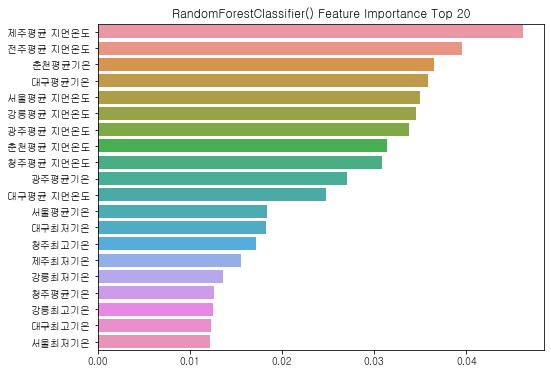

--------------------------------------------------


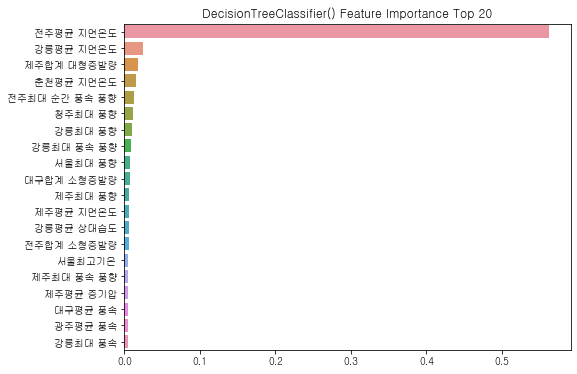

--------------------------------------------------


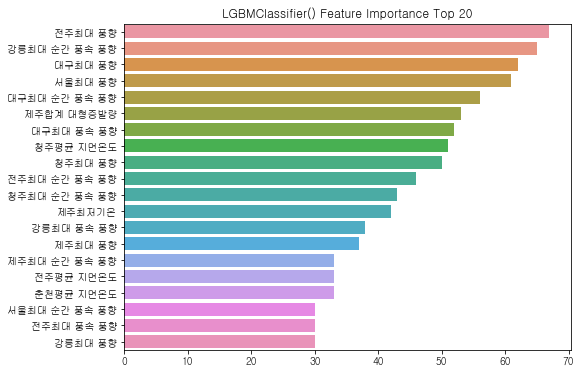

--------------------------------------------------


In [78]:
# from xgboost import XGBClassifier

# # model = XGBClassifier(random_state=11)
# # model.fit(X_train, y_train)

# # 배열형태로 반환
# ft_importance_values = lgbm.feature_importances_

# # 정렬과 시각화를 쉽게 하기 위해 series 전환
# ft_series = pd.Series(ft_importance_values, index = x_train.columns)
# ft_top20 = ft_series.sort_values(ascending=False)[:20]

# # 시각화
# plt.figure(figsize=(8,6))
# plt.title('Feature Importance Top 20')
# sns.barplot(x=ft_top20, y=ft_top20.index)
# plt.show()
model =[rfc, dtc, lgbm]
for i in model:
    # 배열형태로 반환
    ft_importance_values = i.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
    ft_series = pd.Series(ft_importance_values, index = x_train.columns)
    ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
    plt.figure(figsize=(8,6))
    plt.title('{} Feature Importance Top 20'.format(i))
    sns.barplot(x=ft_top20, y=ft_top20.index)
    plt.show()
    print('-'*50)
    
    
    
#피쳐버리는거 이걸로 해봐!!!

In [75]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)